## 各種ライブラリをインポート

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras.datasets import mnist
import keras.backend as K
from tqdm.auto import tqdm

## MNISTデータを取得

In [20]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255 #0~255の範囲の各画素値を0~1までの範囲に正規化(Min-Max normalization)
x_test = x_test/255
classes_num = y_train.max()+1 #全クラス数を計算
img_shape = x_train.shape[1]*x_train.shape[2]

## 学習用画像生成関数(Overlay)を定義

In [21]:
def overlay(x,y):
  """
  オーバーレイ画像を作成。
  各画像(x)の、先頭からクラス数分のピクセルを0埋めし、「その画像に対応するラベル(y)の数字」番目のピクセルを1埋めする。

  Parameters
  ----------
  x : numpy.ndarray
      ラベルを重ねる画像を格納したnumpy配列
  y : numpy.ndarray
      画像に重ね合わせるラベルを格納したnumpy配列
  """
  if x.ndim == 3:#次元数が3なら(Flattenされてないなら)
    x[:,0,:classes_num] = 0 #すべての画像において、最初の行の、クラス数分のピクセルの画素値を0にする
    for i in tqdm(range(x.shape[0])): 
      x[i,0,y[i]] = 1 #すべての画像において、最初の行の、「その画像に対応するラベル(y)の数字」番目のピクセルを1にする
  elif x.ndim == 2: #次元数が2なら(Flattenされているなら)
    x[:,:classes_num] = 0 #すべての画像において、クラス数分のピクセルの画素値を0にする
    x[:,y] = 1 #すべての画像において、「その画像に対応するラベル(y)の数字」番目のピクセルを1にする
  else: #それ以外の場合、例外処理
    raise Exception
  return np.copy(x)

## Neg学習用誤りラベル生成関数(Wrong_label)を定義

In [22]:
def wrong_label(y):
  """
  Negative画像生成用の「誤りラベル」を生成。
  ここで生成したラベルを用いてoverlayを実行することで、誤ったラベルに基づくオーバーレイ画像(Negative画像)を生成できる。

  Parameter
  ----------
  y : numpy.ndarray
      「正しいラベル」を格納したnumpy配列

  Return
  -------
  numpy.ndarray
      誤りラベルを格納したnumpy配列
  """
  print("Create a WRONG_LABEL")
  wrong_label = [] #誤りラベルを格納するための空のリスト
  for i in tqdm(y):
    samples = list(range(classes_num)) #クラス数分のrangeリストを作成
    del samples[i] #「正しい」クラス番号をranegリストから削除。つまりrangeリストに残ったのは「その画像と対応"しない"クラス番号」になる。
    wrong_label.append(np.random.choice(samples)) #rangeリストからランダムに一つ選び、ラベル用リストにappendする。どれを選んでも誤ったラベルになる。 
  print("DONE")
  return np.array(wrong_label) #返り値はnumpy配列に直した誤りラベルリスト

## Positive画像、Negative画像の作成

  0%|          | 0/60000 [00:00<?, ?it/s]

Create a WRONG_LABEL


  0%|          | 0/60000 [00:00<?, ?it/s]

DONE


  0%|          | 0/60000 [00:00<?, ?it/s]

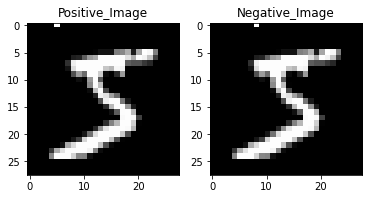

In [23]:
pos = np.copy(x_train)
neg = np.copy(x_train)
overlay(pos, y_train) #Positive画像を作成
overlay(neg, wrong_label(y_train)) #Negative画像を作成
fig,ax = plt.subplots(1, 2)

ax[0].imshow(pos[0], cmap="gray")
ax[0].set_title("Positive_Image")
ax[1].imshow(neg[0], cmap="gray")
ax[1].set_title("Negative_Image")
plt.show() #画像確認

## FFアルゴリズムの損失関数を定義

In [24]:
def FF_Loss(threshold):
  """
  自作の損失関数。といってもここでは逆伝搬を行っていないため、単純に各ニューロンの重み更新式を記述しているに過ぎない。
  Tensorflowの損失関数フォーマットに合わせるため、関数内関数を用いている。
  
  Parameter
  ---------
  threshold : int
      ニューロン活性の指標となる閾値
  
  Retrun
  ------
  Tensor
      損失値
  """
  def myLoss(y_true, y_pred):
    """
    実際にGoodnessを計算する。
    y_trueはpos_neg判定ラベル（pos=-1,neg=1）、y_predはDense層のOutput
    すなわち、Relu(Dot(inputs,weights)+bias)である。

    Parameters
    ----------
    y_true : Tensor
        今がpos学習なのかneg学習なのかを判定するためのラベル群
    y_pred : Tensor
        Relu(Dot(inputs,weights)+bias)

    Return
    ------
    Tensor
        損失値
    """
    g = K.pow(y_pred, 2) #y_predの値を2乗する
    g = K.mean(g, axis=1)
    g = g - threshold #gからthresholdの値を引く
    g = g * y_true #gにy_trueの値をかける
    #y_trueの値は、pos学習の場合-1、neg学習の場合1である。
    #今回の損失関数の目的は、pos学習の場合y_pred^2>>threshold、neg学習の場合y_pred^2<<thresholdとなることである。
    #つまり、pos学習の場合は(y_pred^2-threshold)が大きくなれば学習が進んでいることになる。neg学習の場合は小さくなれば良い。
    #よって、各ニューロンの重み更新に用いる損失値は、pos学習の場合-(y_pred^2-threshold)、neg学習の場合(y_pred^2-threshold)となる。
    loss = K.log(1 + K.exp(g)) #Softplus関数で損失値の下限を0に漸近させる。詳しくは下のグラフを参照されたし。
    loss = K.mean(loss)
    return loss
  
  return myLoss

参考までに、Softplus関数の概形

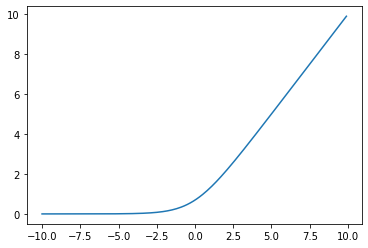

In [25]:
t = np.arange(-10,10,0.1)
y = np.log(1+np.exp(t))
plt.plot(t,y)

## Flatten作業

In [26]:
print(f"before_shape:{pos.shape},{neg.shape}")
pos = pos.reshape(pos.shape[0], -1) 
neg = neg.reshape(neg.shape[0], -1)
print(f"reshape_shape:{pos.shape},{neg.shape}")

before_shape:(60000, 28, 28),(60000, 28, 28)
reshape_shape:(60000, 784),(60000, 784)


## 正規化関数の定義

In [27]:
def normalize_activation(x):
  """
  FFアルゴリズムにおいて、多層学習を行うために必要な処理。
  上層から流れてきたデータは、入力データにおける上層ニューロンの「活動ベクトル」である。
  上層が32次元のOutputを出すのであれば、上層ニューロンの活動ベクトルは32次元のベクトルになる。
  この活動ベクトルは、ベクトルというだけあって向きと長さを持つ。
  向きはニューロンの相対活動(32次元であれば、32個の重みの比率)であり、長さはその層の精度(どれだけ活性化していたか)の情報である。
  ここでもし、この活動ベクトルをそのまま下層に流してしまうと、上層のニューロンの活性状態が下層の出力に大きく影響してしまう恐れがある。（上の層が高い活性化状態にあっただけで、下の層も高い活性化を示してしまいかねない。）
  それだと、下層は上層のコピーのような存在になってしまい、深層学習にならない。
  それを避けるために、FFアルゴリズムでは活動ベクトルをそのL2ノルムで除算し、上層の精度決定で使用された情報をすべて取り除いてから下層に流す。(従来のNNにおけるactivation層みたいなもの)
  ここでは、その除算を関数として定義している。

  Parameter
  ---------
  x : Tensor
      処理前の活動ベクトル
  
  Return
  ------
  Tensor
      L2ノルムで除算した活動ベクトル

  """
  return x / (tf.norm(x, ord=2, axis=1, keepdims=True) + 1e-4) #L2ノルムで活動ベクトルを除算。(ZeroDivisionError対策に微小量を分母に足している。)

## 各層を個別のSequentialモデルとして定義

In [28]:
threshold = 2
layer1 = keras.Sequential([
    keras.layers.Dense(500, activation="relu", input_shape=[img_shape])
])
layer1.compile(loss=FF_Loss(threshold), optimizer=keras.optimizers.Adam())

In [29]:
layer2 = keras.Sequential([
    keras.layers.Dense(500, activation="relu", input_shape=[500])
])
layer2.compile(loss=FF_Loss(threshold), optimizer=keras.optimizers.Adam())

In [30]:
layer1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 500)               392500    
                                                                 
Total params: 392,500
Trainable params: 392,500
Non-trainable params: 0
_________________________________________________________________


In [31]:
layer2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
Total params: 250,500
Trainable params: 250,500
Non-trainable params: 0
_________________________________________________________________


## Test用関数の定義

In [32]:
def test_list_maker(imgs):
  """
  性能評価用画像生成関数
  判定したい画像をもとに、各クラスに対応したOverlay画像を生成する。(つまり生成されるOverlay画像はクラス数分)

  Parameter
  ---------
  imgs : numpy.array
      判定したい画像群が格納された配列
  
  Return
  ------
  numpy.array
      性能評価用画像群が格納された配列
  """
  test_list = np.array([overlay(np.copy(imgs).reshape((imgs.shape[0],-1)),i) for i in range(classes_num)])
  return test_list

In [33]:
  def test(x_test_list,y_test,ret = "num"):
    """
    性能評価用関数
    test_list_makerで作成した画像群を用いて実際に各層に予想をさせる。

    Parameters
    ----------
    x_test_label:numpy.array
        性能評価用画像群が格納された配列
    y_test:numpy.array
        正解ラベル

    Return
    ------
    int
        正解数
    """
    l1_predict = np.rot90(np.array([layer1.predict(x_test_list[:,i], verbose=0) for i in range(classes_num)])) #各Overlay画像に対する1層目の予測。verbode = 0で邪魔な標準出力を消している。rot90はshapeを(画像枚数,クラス数,総ピクセル数)に変更するためつけている。
    l1_predict_normed = np.rot90(np.array([normalize_activation(l1_predict[:,i]) for i in range(classes_num)])) #1層目の予測情報を正規化
    l2_predict = np.rot90(np.array([layer2.predict(l1_predict_normed[:,i], verbose=0) for i in range(classes_num)])) #2層目の予測。
    ans = np.array(np.mean(np.power(l1_predict, 2),axis=2) + np.mean(np.power(l2_predict, 2),axis=2)) #それぞれの予測結果の2乗平均を足し合わせる。
    ans = np.argmax(ans,axis = 1)#最も高い活動を示したものが「正しい組み合わせ」であるから、argmaxで最も高い活動を示した値のindexを取得。
    if(ret == "num"):
      return np.count_nonzero(ans==y_test)#正解数を返却。
    elif(ret == "list"):
      return np.array(ans == y_test)

## 1層目の学習

In [34]:
batch_size = 100
epoch_num = 60
y_pos = np.ones((batch_size)) * -1 #Pos学習において、損失値が(y_pred^2 >> Threshold)を目指すようにするために使う-1パラメータ(FF_Lossのy_true)。詳しくはFF_Lossのドキュメントを参照されたし。
y_neg = np.ones((batch_size)) #Neg学習用パラメータ。これもFF_Lossのドキュメントを参照されたし。
pos_history = [] #Pos学習における損失値の推移を格納する空のリスト
neg_history = [] #Neg学習における損失値の推移を格納する空のリスト
for ep in tqdm(range(epoch_num)):
  print(f"epoch:{ep}")
  for b in tqdm(range(pos.shape[0] // batch_size)):
    x = pos[b * batch_size: (b + 1) * batch_size]
    pos_history.append(layer1.train_on_batch(x, y_pos))
    x = neg[b * batch_size: (b + 1) * batch_size]
    neg_history.append(layer1.train_on_batch(x, y_neg))

  0%|          | 0/60 [00:00<?, ?it/s]

epoch:0


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:1


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:2


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:3


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:4


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:5


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:6


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:7


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:8


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:9


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:10


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:11


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:12


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:13


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:14


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:15


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:16


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:17


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:18


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:19


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:20


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:21


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:22


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:23


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:24


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:25


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:26


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:27


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:28


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:29


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:30


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:31


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:32


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:33


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:34


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:35


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:36


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:37


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:38


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:39


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:40


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:41


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:42


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:43


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:44


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:45


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:46


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:47


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:48


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:49


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:50


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:51


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:52


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:53


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:54


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:55


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:56


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:57


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:58


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:59


  0%|          | 0/600 [00:00<?, ?it/s]

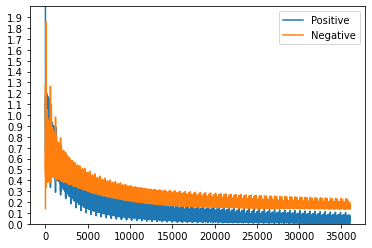

In [35]:
#1層目のLossの推移
y = np.arange(0,2,0.1)
plt.figure()
plt.yticks(y)
plt.ylim([0,2])
plt.plot(pos_history,label = "Positive")
plt.plot(neg_history,label = "Negative")
plt.legend()
plt.show()

## 2層目に流す正規化済み情報の作成

In [36]:
pos1 = layer1.predict(pos)
print(pos.shape)
neg1 = layer1.predict(neg)
del pos,neg
pos1 = normalize_activation(pos1)
neg1 = normalize_activation(neg1)
print(pos1.shape, neg1.shape)

1875/1875 [==============================] - 6s 3ms/step
(60000, 784)
1875/1875 [==============================] - 6s 3ms/step
(60000, 500) (60000, 500)


## 2層目の学習

In [37]:
pos_history_2 = []
neg_history_2 = []
for ep in tqdm(range(epoch_num)):
  print(f"epoch:{ep}")
  for b in tqdm(range(pos1.shape[0] // batch_size)):
    x = pos1[b * batch_size: (b + 1) * batch_size]
    pos_history_2.append(layer2.train_on_batch(x, y_pos))
    x = neg1[b * batch_size: (b + 1) * batch_size]
    neg_history_2.append(layer2.train_on_batch(x, y_neg))

  0%|          | 0/60 [00:00<?, ?it/s]

epoch:0


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:1


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:2


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:3


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:4


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:5


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:6


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:7


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:8


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:9


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:10


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:11


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:12


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:13


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:14


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:15


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:16


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:17


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:18


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:19


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:20


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:21


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:22


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:23


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:24


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:25


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:26


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:27


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:28


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:29


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:30


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:31


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:32


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:33


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:34


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:35


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:36


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:37


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:38


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:39


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:40


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:41


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:42


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:43


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:44


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:45


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:46


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:47


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:48


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:49


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:50


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:51


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:52


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:53


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:54


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:55


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:56


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:57


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:58


  0%|          | 0/600 [00:00<?, ?it/s]

epoch:59


  0%|          | 0/600 [00:00<?, ?it/s]

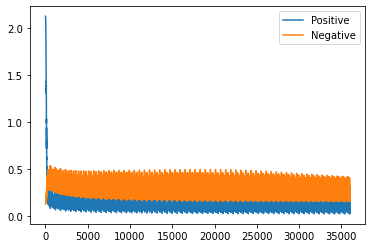

In [38]:
#2層目のLossの推移
plt.plot(pos_history_2,label = "Positive")
plt.plot(neg_history_2,label = "Negative")
plt.legend()
plt.show()
del pos1,neg1

## TrainとTestのデータ10000枚に対する予測と、その精度

In [39]:
x_train_list = np.rot90(test_list_maker(x_train[:10000]))#rot90はshapeを(画像枚数,クラス数,総ピクセル数)に変更するためつけている。
accuracy = test(x_train_list,y_train[:10000])
print(f"trainデータの予測結果:{100*accuracy/x_train_list.shape[0]}%")

trainデータの予測結果:96.39%


In [40]:
x_test_list = np.rot90(test_list_maker(x_test))#rot90はshapeを(画像枚数,クラス数,総ピクセル数)に変更するためつけている。
accuracy = test(x_test_list,y_test)
print(f"testデータの予測結果:{100*accuracy/x_test_list.shape[0]}%")

testデータの予測結果:95.74%
